In [1]:
import os

import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt


MODEL_DIR = "./saved_models"
DATASET_PREFIX = "./data/MNIST"
DATA_PATH = f"{DATASET_PREFIX}/raw/mnist_dataset.csv"
CHECKPOINT_FREQ = 5
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
NUM_CLASSES = 10
 

def custom_collate_fn(batch):
    def load_image_tensor(filepath):
        img = Image.open(filepath)
        transform = transforms.Compose([
            transforms.PILToTensor()
        ])
        img_tensor = transform(img)
        return img_tensor.to(DEVICE)

    images_tensor = torch.cuda.FloatTensor(len(batch), 28, 28)
    torch.cat([load_image_tensor(f"{DATASET_PREFIX}/{item[0]}") for item in batch], out=images_tensor)
    labels_tensor = torch.cuda.FloatTensor([item[1] for item in batch])
    return (images_tensor.to(DEVICE), labels_tensor.type(torch.int64).to(DEVICE))


class MNISTDataset(Dataset):
    def __init__(self, filepath: str):
        super().__init__()
        self.dataframe = pd.read_csv(filepath)
    
    def __len__(self):
        return len(self.dataframe)
        
    def __getitem__(self, idx):
        return self.dataframe.iloc[idx]

    
def load_data(batch_sz=100, train_val_test_split=[0.8, 0.1, 0.1]):
    assert sum(train_val_test_split) == 1, "Train, val and test fractions should sum to 1!"
    train_dataset = MNISTDataset(DATA_PATH)
    train_val_split = list(map(lambda split: round(split * len(train_dataset)), train_val_test_split))
    train_split, val_split, test_split = random_split(train_dataset, train_val_split)
    train_dl = DataLoader(train_split, 
                          batch_size=batch_sz, 
                          shuffle=True, 
                          collate_fn=custom_collate_fn)
    val_dl = DataLoader(val_split, 
                        batch_size=batch_sz, 
                        shuffle=True, 
                        collate_fn=custom_collate_fn)
    test_dl = DataLoader(test_split,
                         batch_size=batch_sz,
                         shuffle=False,
                         collate_fn=custom_collate_fn)
    return train_dl, val_dl, test_dl
                
    
def image_grid(dataset, ncols=4):
    images_only = dataset
    height, width = dataset[0].shape
    nrows = len(images_only)//ncols
    
    img_grid = (dataset.reshape(nrows, ncols, height, width)
              .swapaxes(1,2)
              .reshape(height*nrows, width*ncols))
    
    return img_grid


def show_batch(dataset, title="Image batch", cols=4):
    N = len(dataset)
    if N > cols:
        assert N % cols == 0, "Number of cols must be a multiple of N"
    
    result = image_grid(dataset)
    fig = plt.figure(figsize=(5., 5.))
    plt.suptitle(f"{title} [{int(N/cols)}x{cols}]")
    plt.imshow(result.cpu())


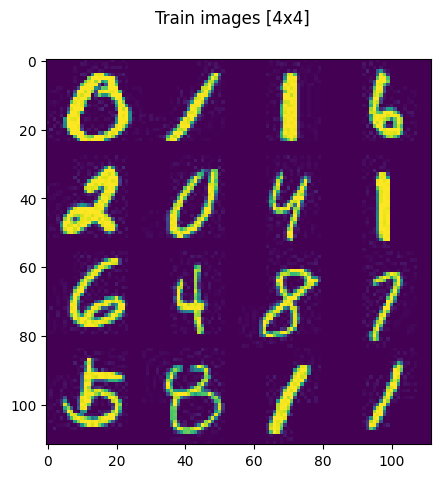

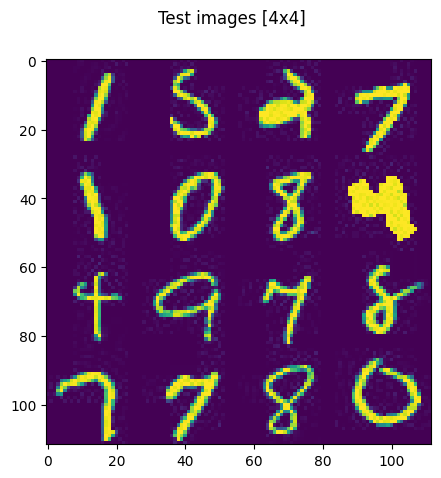

In [2]:
train_dl, val_dl, test_dl = load_data(batch_sz=16)

train_images, _ = next(iter(train_dl))
test_images, _ = next(iter(test_dl))

show_batch(train_images, title="Train images", cols=4)
show_batch(test_images, title="Test images", cols=4)

In [3]:
import torch.nn as nn 


def save_model(model, epoch, save_dir):
    filename = f"checkpoint_{epoch}.pth"
    save_path = os.path.join(save_dir, filename)
    torch.save(model, save_path)



simple_seq_net = nn.Sequential(
    nn.Conv2d(
        
        in_channels=1,              
        out_channels=16,            
        kernel_size=5,              
        stride=1,                   
        padding=2,                  
    ),                              
    nn.ReLU(),                      
    nn.MaxPool2d(kernel_size=2),
    nn.Conv2d(16, 32, 5, 1, 2),     
    nn.ReLU(),                      
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(32 * 7 * 7, NUM_CLASSES)
)




In [4]:
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample):
        super().__init__()
        if downsample:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
            self.shortcut = nn.Sequential()

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, inp):
        shortcut = self.shortcut(inp)
        inp = nn.ReLU()(self.bn1(self.conv1(inp)))
        inp = nn.ReLU()(self.bn2(self.conv2(inp)))
        inp = inp + shortcut
        return nn.ReLU()(inp)
    


class ResNet(nn.Module):
    def __init__(self, in_channels, resblock, outputs):
        super().__init__()
        self.layer0 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.layer1 = nn.Sequential(
            resblock(64, 64, downsample=False),
            resblock(64, 64, downsample=False)
        )

        self.layer2 = nn.Sequential(
            resblock(64, 128, downsample=True),
            resblock(128, 128, downsample=False)
        )

        self.layer3 = nn.Sequential(
            resblock(128, 256, downsample=True),
            resblock(256, 256, downsample=False)
        )


        self.layer4 = nn.Sequential(
            resblock(256, 512, downsample=True),
            resblock(512, 512, downsample=False)
        )

        self.gap = nn.AdaptiveAvgPool2d(1)
        self.flat = nn.Flatten() 
        self.fc = nn.Linear(512, outputs)

    def forward(self, inp):
        inp = self.layer0(inp)
        inp = self.layer1(inp)
        inp = self.layer2(inp)
        inp = self.layer3(inp)
        inp = self.layer4(inp)
        inp = self.gap(inp)
        inp = self.flat(inp)
        inp = self.fc(inp)

        return inp
    

In [5]:
from torch.utils.tensorboard import SummaryWriter



# Need to work in Early stopping (https://stackoverflow.com/questions/71998978/early-stopping-in-pytorch) and Learning Rate scheduling (https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate)
def train_model(model, epochs, dataloaders, checkpoint_frequency=5):
    writer = SummaryWriter()
    for epoch in range(epochs):
        for phase in ['train', 'val']:
            if phase == "train":
                model.train()
            else:
                model.eval()
            total_steps = len(dataloaders[phase])

            correct = 0
            total = 0
            
            for batch_num, (image_batch, label_batch) in enumerate(dataloaders[phase]):
                optim.zero_grad()
                batch_sz = len(image_batch)
                image_batch = image_batch.reshape(batch_sz, 1, 28, 28)            


                output = model(image_batch)
                losses = loss_fn(output, label_batch)

                if phase == "train":
                    losses.backward()
                    optim.step()


                preds = torch.argmax(output, dim=1)
                correct += int(torch.eq(preds, label_batch).sum())
                total += label_batch.shape[0]
                writer.add_scalar(f'Loss/{phase}', losses.item(), (epoch*epochs) + batch_num)
                if (batch_num + 1) % 10 == 0:
                    print (f'Epoch[{epoch+1}/{epochs}], Step[{batch_num + 1}/{total_steps}], Loss({phase}): {losses.item():.4f}, Acc({phase}): {correct/total:.3f}',
                           end="\r" if epoch < epochs else "\n", 
                           flush=True)
            accuracy = 100 * correct / total

            writer.add_scalar(f'Acc/{phase}', accuracy, epoch)
            if phase == "val":
                if (epoch + 1) % checkpoint_frequency == 0:
                    save_model(model, epoch + 1, "./saved_models")
                    

def test_model(model, dataloaders):
    writer = SummaryWriter()
    model.eval()
    correct = 0
    total = 0
    total_steps = len(dataloaders['test'])
    for batch_num, (image_batch, label_batch) in enumerate(dataloaders['test']):
        batch_sz = len(image_batch)
        image_batch = image_batch.reshape(batch_sz, 1, 28, 28)
        out = model(image_batch)
        preds = torch.argmax(out, dim=1)
        correct += int(torch.eq(preds, label_batch).sum())
        total += label_batch.shape[0]
        if (batch_num + 1) % 10 == 0:
            print (f'Testing batch[{batch_num + 1}/{total_steps}]',
                   end="\r" if batch_num < total_steps else "\n", 
                   flush=True)
    print(f"Final test accuracy for {total} examples: {correct/total:.3f}")
        


In [6]:
epochs = 15
train_batch_sz = val_batch_sz = 128
learning_rate = 0.001 

train_dl, val_dl, test_dl = load_data(batch_sz=train_batch_sz)
dataloaders = {'train': train_dl, 'val': val_dl, 'test': test_dl}




network = ResNet(1, ResBlock, outputs=NUM_CLASSES)
# network = simple_seq_net
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.Adam(network.parameters(), lr=learning_rate)
network = network.to(DEVICE)


train_model(network, epochs, dataloaders)

KeyboardInterrupt: 

In [ ]:
loaded_net = torch.load("./saved_models/checkpoint_15.pth")
test_model(loaded_net, dataloaders)